In [2]:
# 1. Imports
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# 2. Load and Preprocess Data
df = pd.read_csv(r"C:\Users\nithi\Downloads\ML-model\normalized_tx_dataset.csv", low_memory=False, nrows=30000)
group_ref = pd.read_csv(r"C:\Users\nithi\Downloads\001-SAS-Benefits-Cost-sharing\BENEFIT_GROUPED.csv")

# 3. Merge and Clean
df["BenefitName"] = df["BenefitName"].astype(str).str.strip().str.title()
group_ref["BenefitName"] = group_ref["BenefitName"].astype(str).str.strip().str.title()
df = pd.merge(df, group_ref, how="left", on="BenefitName")
df.dropna(subset=["BenefitGroupID"], inplace=True)

# 4. Drop Irrelevant Columns
irrelevant_cols = ["BusinessYear", "IssuerId", "StandardComponentId", "PlanId", "SourceName", "ImportDate"]
df.drop(columns=[col for col in irrelevant_cols if col in df.columns], inplace=True, errors='ignore')

# 5. Encode Target
le = LabelEncoder()
df["GroupLabel"] = le.fit_transform(df["BenefitGroupID"])

# 6. Clean and Fill Numeric Features
cost_columns = [
    "CopayInnTier1", "CopayInnTier2", "CopayOutofNet",
    "CoinsInnTier1", "CoinsInnTier2", "CoinsOutofNet"
]
for col in cost_columns:
    df[col] = df[col].astype(str).str.replace(r"[^\d.]", "", regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[cost_columns] = df[cost_columns].fillna(df[cost_columns].median())

# 7. Select Features
X = df.select_dtypes(include=[np.number]).drop(columns=["GroupLabel"])
X = X.fillna(X.median())
y = df["GroupLabel"]

# 8. Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 9. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 10. Lightweight Tuning: Try a few key combinations
best_f1 = 0
best_model = None

for n in [100, 150, 200]:
    for d in [10, 15, 20]:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        f1 = f1_score(y_test, preds, average='macro')

        print(f"n_estimators: {n}, max_depth: {d}, F1: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_model = rf

# 11. Final Evaluation
y_pred_best = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_best)
final_f1 = f1_score(y_test, y_pred_best, average='macro')

print("\n✅ Best Lightweight Model Performance:")
print("Best F1 Score:", round(final_f1, 4))
print("Improved Accuracy:", round(final_accuracy, 4))

# 13. ✅ Save the Best Model
joblib.dump(best_model, "rf_model.pkl")
print("Model saved as 'rf_model.pkl'")


n_estimators: 100, max_depth: 10, F1: 0.8889
n_estimators: 100, max_depth: 15, F1: 0.9405
n_estimators: 100, max_depth: 20, F1: 0.9911
n_estimators: 150, max_depth: 10, F1: 0.8826
n_estimators: 150, max_depth: 15, F1: 0.9496
n_estimators: 150, max_depth: 20, F1: 0.9915
n_estimators: 200, max_depth: 10, F1: 0.8664
n_estimators: 200, max_depth: 15, F1: 0.9462
n_estimators: 200, max_depth: 20, F1: 0.9910

✅ Best Lightweight Model Performance:
Best F1 Score: 0.9915
Improved Accuracy: 0.9908
Model saved as 'rf_model.pkl'


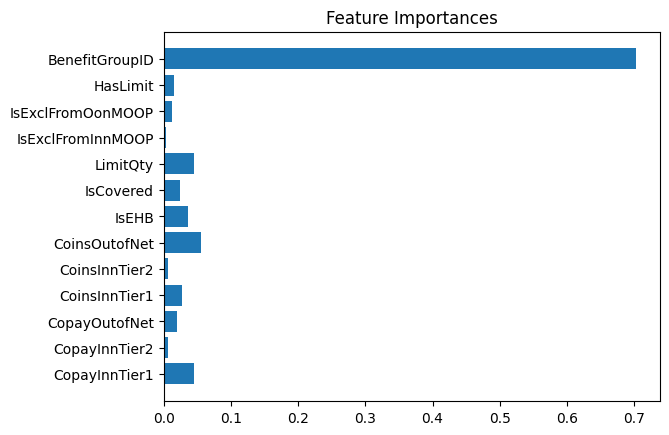

In [3]:
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
plt.barh(df.select_dtypes(include=[np.number]).drop(columns=["GroupLabel"]).columns, importances)
plt.title("Feature Importances")
plt.show()


In [7]:
import streamlit as st
import pandas as pd
import joblib
import os

# Load normalized dataset
@st.cache_data
def load_data():
    df = pd.read_csv("normalized_tx_dataset.csv", low_memory=False)
    df = df.dropna(subset=['BenefitName'])
    return df

# Load ML model
@st.cache_resource
def load_model():
    model_path = "rf_model.pkl"
    if os.path.exists(model_path):
        return joblib.load(model_path)
    else:
        st.warning("⚠️ Machine learning model not found. Please make sure 'rf_model.pkl' is in the same folder as this app.")
        return None

model = load_model()
df = load_data()

# Set up page configuration
st.set_page_config(page_title="Compare Insurance Plans Easily", layout="wide")
st.title("\U0001F4B8 Insurance Plan Explorer")

st.markdown("""
Use this tool to compare different **health insurance benefits** and explore how affordable and essential they are.
We simplify complex terms into clear, helpful information so you can make the best choice.
""")

# User selects a benefit to explore
benefit_options = sorted(df['BenefitName'].unique())
selected_benefit = st.selectbox("Choose a Health Benefit (e.g., Dental, Emergency Care):", benefit_options)

# Filter plans for the selected benefit
filtered = df[df['BenefitName'] == selected_benefit].copy()

# Friendly column mapping for display
display_df = filtered.rename(columns={
    'PlanId': 'Plan ID',
    'CopayInnTier1': 'In-Network Copay (Tier 1)',
    'CopayInnTier2': 'In-Network Copay (Tier 2)',
    'CopayOutofNet': 'Out-of-Network Copay',
    'CoinsInnTier1': 'In-Network Coinsurance % (Tier 1)',
    'CoinsInnTier2': 'In-Network Coinsurance % (Tier 2)',
    'CoinsOutofNet': 'Out-of-Network Coinsurance %',
    'IsExclFromInnMOOP': 'Excluded from In-Network MOOP?',
    'IsExclFromOonMOOP': 'Excluded from Out-of-Network MOOP?',
    'BenefitCategory': 'Benefit Category'
})

# Show plans
st.subheader(f"\U0001F50E Available Plans for: {selected_benefit}")
if display_df.empty:
    st.error("No plans found for this benefit. Please try another.")
else:
    st.dataframe(display_df[[
        'Plan ID', 'In-Network Copay (Tier 1)', 'In-Network Copay (Tier 2)',
        'Out-of-Network Copay', 'In-Network Coinsurance % (Tier 1)',
        'In-Network Coinsurance % (Tier 2)', 'Out-of-Network Coinsurance %',
        'Excluded from In-Network MOOP?', 'Excluded from Out-of-Network MOOP?',
        'Benefit Category'
    ]])

    # ML Prediction Section
    if model:
        st.markdown("### \U0001F4C8 Predicted Affordability Category")
        feature_columns = [
            "CopayInnTier1", "CopayInnTier2", "CopayOutofNet",
            "CoinsInnTier1", "CoinsInnTier2", "CoinsOutofNet",
            "IsCovered", "IsEHB", "IsExclFromInnMOOP", "IsExclFromOonMOOP",
            "LimitQty", "HasLimit", "GroupLabel"
        ]

        available_cols = [col for col in feature_columns if col in filtered.columns]
        prediction_input = filtered[available_cols].copy()
        prediction_input = prediction_input.apply(pd.to_numeric, errors='coerce').fillna(0)

        try:
            prediction = model.predict(prediction_input)
            display_df['Predicted Affordability'] = prediction
            st.dataframe(display_df[['Plan ID', 'Benefit Category', 'Predicted Affordability']])
        except Exception as e:
            st.error(f"Prediction failed: {e}")

# Glossary for user understanding
with st.expander("\u2139\ufe0f Click here to understand the terms"):
    st.markdown("""
    - **Copay**: A fixed fee you pay for a specific health service (like $20 for a doctor visit).
    - **Coinsurance**: A percentage of costs you pay after your deductible is met.
    - **In-Network**: Providers who have special pricing contracts with your insurer.
    - **Out-of-Network**: Providers outside of contract, usually more expensive.
    - **MOOP**: Maximum Out-of-Pocket — the max you’ll pay in a year before insurance covers 100%.
    - **Affordability Prediction**: Based on your plan's features, we use AI to suggest if the plan is cost-friendly.
    """)


2025-04-06 12:17:53.390 No runtime found, using MemoryCacheStorageManager
2025-04-06 12:17:53.392 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 12:17:53.392 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 12:17:53.392 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 12:17:53.513 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 12:17:53.514 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 12:17:53.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 12:17:53.657 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 12:17:53.657 Thread 'MainThread':